* [Quick Start — pyGAM documentation](https://pygam.readthedocs.io/en/latest/notebooks/quick_start.html)
* [A Tour of pyGAM — pyGAM documentation](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html#API)
* pygam has been installed in the base conda environment
* scikit-sparse cause problem if installed, the problem seems to be from numpy
* low-mass halos has large discreteness, add noise to all halo masses to suppress this

In [1]:
from pygam import LinearGAM, s
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import bigfile

root_path = '/mnt/sdceph/users/yinli/csit/planck2015/'

sim_types = ['iso', 'mmp', 'ppm']

In [2]:
boxsize = 1000

lambdaz = 0.05

def s2(lambdaz):
    return 1.5 * lambdaz ** 2

seeds = range(1991, 1992)

In [3]:
def get_halo_masses(boxsize, lambdaz, seeds):
    """Return preprocessed halo masses.
    
    Procedures:
    -----------
    concatenate,
    Sort, before truncate to discard extra low-mass halos
    Truncate, before adding noise to not introduce a bias at low mass end
    Add noise, to suppress the discretness at low mass end
    Sort again, to get catalogs in descending order at the end
    """
    M = {}

    for t in sim_types:

        def nodot(s):
            return str(s).replace('.', '')

        if t != 'iso':
            t_str = f'{t}{nodot(lambdaz)}'
        else:
            t_str = t
        
        halo_files = [f'{root_path}/{boxsize}/{seed}/{t_str}/ASMTH6/halos/'
                      for seed in seeds]

        M[t] = np.empty(0)

        for f in halo_files:
            cat_ = bigfile.BigFile(f)
            M_ = cat_['Mass'][:]
            M[t] = np.concatenate([M[t], M_])

        M[t] = np.sort(M[t])[::-1]

    length = min(len(M[t]) for t in sim_types)
    print(f'Found {length:.2e} matchable halos')

    frac = 0.1  # fraction of minimum halo mass
    noise_std = frac * min(M[t][-1] for t in sim_types)

    for t in sim_types:
        M[t] = M[t][:length]

        M[t] += noise_std * np.random.randn(len(M[t]))

        M[t] = np.sort(M[t])[::-1]
    
    return M


def get_mass_shift(Ma, Mb, lambdaz, n_splines=4, lams=np.logspace(-6, 0, 7)):
    lnMa, lnMb = np.log(Ma), np.log(Mb)
    lnM = 0.5 * (lnMa + lnMb)
    shift = (lnMb - lnMa) / s2(lambdaz)
    
    gam = LinearGAM(s(0, n_splines=n_splines), fit_intercept=False, verbose=True)
    gam = gam.gridsearch(lnM[:, None], shift, lam=lams)
    
    gam.summary()
    print(gam.statistics_)
    print(gam.terms[0].lam)
    
    lnM_ = gam.generate_X_grid(0)
    shift_, shift_w_err = gam.partial_dependence(0, X=lnM_, width=.68)
    
    return np.exp(lnM_).squeeze(), shift_

def plt_mass_shift_scatter(Ma, Mb, lambdaz):
    lnMa, lnMb = np.log(Ma), np.log(Mb)
    lnM = 0.5 * (lnMa + lnMb)
    shift = (lnMb - lnMa) / s2(lambdaz)
    
    plt.scatter(np.exp(lnM), shift, s=0.5, alpha=0.2)


def get_mass_func(M, boxsize, n_splines=4, lams = np.logspace(-6, 0, 7)):
    """Cumulative mass function"""
    lnn = np.log(np.arange(1, 1 + len(M)) * boxsize ** -3)
    lnM = np.log(M)
    
    gam = LinearGAM(s(0, n_splines=n_splines), fit_intercept=False, verbose=True)
    gam = gam.gridsearch(lnM[:, None], lnn, lam=lams)
    
    gam.summary()
    print(gam.statistics_)
    print(gam.terms[0].lam)
    
    lnM_ = gam.generate_X_grid(0)
    lnn_, lnn_w_err = gam.partial_dependence(0, X=lnM_, width=.68)
    
    lnM_ = lnM_.squeeze()
    M_, n_ = np.exp(lnM_), np.exp(lnn_)
    
    # Use spline derivative to get differential mass function
    # - d / dlnM
    dlnn_dlnM = CubicSpline(lnM_, lnn_).derivative(1)
    dlnn_dlnM_ = dlnn_dlnM(lnM_)
    n_p_ = - dlnn_dlnM_ * n_  # n_p_ = n_lnM
    
    dlnnp_dlnM = CubicSpline(lnM_, np.log(n_p_)).derivative(1)
    dlnnp_dlnM_ = dlnnp_dlnM(lnM_)
    n_pp_ = - dlnnp_dlnM_ * n_p_
    
    # mass,
    # cumulative mass function (>M),
    # - d n / d ln M = n_lnM
    # (- d / d ln M)^2 n
    return M_, n_, n_p_, n_pp_


def plt_mass_func_scatter(M, boxsize):
    """Cumulative mass function"""
    n = np.arange(1, 1 + len(M)) * boxsize ** -3
    
    plt.scatter(M, n, s=0.5, alpha=0.2)

In [4]:
M = get_halo_masses(boxsize, lambdaz, seeds)

Found 2.83e+06 matchable halos


N/A% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--/home/yinli/anaconda/lib/python3.7/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
100% (7 of 7) |##########################| Elapsed Time: 0:01:10 Time:  0:01:10
/home/yinli/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

N/A% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      3.9996
Link Function:                     IdentityLink Log Likelihood:                             -94297085.7684
Number of Samples:                      2831339 AIC:                                        188594181.5361
                                                AICc:                                       188594181.5361
                                                GCV:                                                0.0136
                                                Scale:                                              0.0136
                                                Pseudo R-Squared:                                   0.2185
Feature Function                  Lam

/home/yinli/anaconda/lib/python3.7/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
100% (7 of 7) |##########################| Elapsed Time: 0:01:05 Time:  0:01:05
/home/yinli/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:60: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                         4.0
Link Function:                     IdentityLink Log Likelihood:                             -49670775.0495
Number of Samples:                      2831339 AIC:                                          99341560.099
                                                AICc:                                         99341560.099
                                                GCV:                                                0.0246
                                                Scale:                                              0.0246
                                                Pseudo R-Squared:                                   0.7537
Feature Function                  Lam

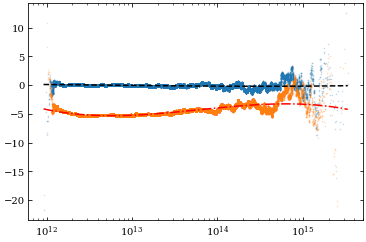

In [8]:
M_mmp, shift_mmp = get_mass_shift(M['iso'], M['mmp'], lambdaz, n_splines=4)
M_ppm, shift_ppm = get_mass_shift(M['iso'], M['ppm'], lambdaz, n_splines=4)

plt_mass_shift_scatter(M['iso'], M['mmp'], lambdaz)
plt_mass_shift_scatter(M['iso'], M['ppm'], lambdaz)
plt.plot(M_mmp, shift_mmp, c='k', ls='--')
plt.plot(M_mmp, shift_ppm, c='r', ls='-.')
plt.xscale('log')

(-3, 3)

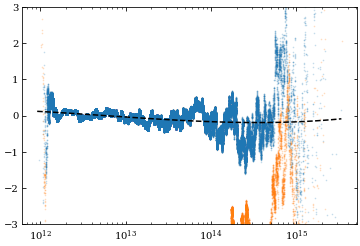

In [7]:
plt_mass_shift_scatter(M['iso'], M['mmp'], lambdaz)
plt_mass_shift_scatter(M['iso'], M['ppm'], lambdaz)
plt.plot(M_mmp, shift_mmp, c='k', ls='--')
plt.plot(M_ppm, shift_ppm, c='r', ls='-.')
plt.xscale('log')
plt.ylim(-3, 3)

N/A% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--/home/yinli/anaconda/lib/python3.7/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
100% (7 of 7) |##########################| Elapsed Time: 0:01:06 Time:  0:01:06
/home/yinli/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:85: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                         4.0
Link Function:                     IdentityLink Log Likelihood:                           -3016328442.6717
Number of Samples:                      2831339 AIC:                                       6032656895.3434
                                                AICc:                                      6032656895.3435
                                                GCV:                                                0.0005
                                                Scale:                                              0.0005
                                                Pseudo R-Squared:                                   0.9995
Feature Function                  Lam

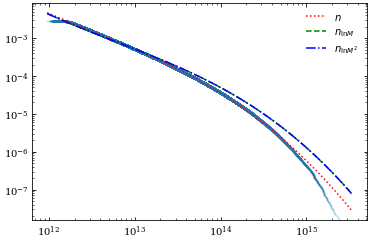

In [9]:
M_, n_, n_p_, n_pp_ = get_mass_func(M['iso'], boxsize, n_splines=4)

plt_mass_func_scatter(M['iso'], boxsize)
plt.plot(M_, n_, c='r', ls=':', label='$n$')
plt.plot(M_, n_p_, c='g', ls='--', label='$n_{\ln M}$')
plt.plot(M_, n_p_, c='b', ls='-.', label='$n_{{\ln M}^2}$')
plt.xscale('log')
plt.yscale('log')
plt.legend()

N/A% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--/home/yinli/anaconda/lib/python3.7/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
100% (7 of 7) |##########################| Elapsed Time: 0:01:11 Time:  0:01:11
/home/yinli/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:85: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                         4.0
Link Function:                     IdentityLink Log Likelihood:                           -3015601030.8902
Number of Samples:                      2831339 AIC:                                       6031202071.7803
                                                AICc:                                      6031202071.7804
                                                GCV:                                                0.0005
                                                Scale:                                              0.0005
                                                Pseudo R-Squared:                                   0.9995
Feature Function                  Lam

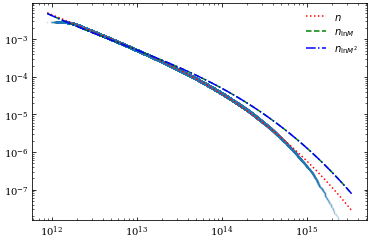

In [10]:
M_, n_, n_p_, n_pp_ = get_mass_func(M['mmp'], boxsize, n_splines=4)

plt_mass_func_scatter(M['mmp'], boxsize)
plt.plot(M_, n_, c='r', ls=':', label='$n$')
plt.plot(M_, n_p_, c='g', ls='--', label='$n_{\ln M}$')
plt.plot(M_, n_p_, c='b', ls='-.', label='$n_{{\ln M}^2}$')
plt.xscale('log')
plt.yscale('log')
plt.legend()

N/A% (0 of 7) |                          | Elapsed Time: 0:00:00 ETA:  --:--:--/home/yinli/anaconda/lib/python3.7/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
100% (7 of 7) |##########################| Elapsed Time: 0:01:10 Time:  0:01:10
/home/yinli/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:85: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                         4.0
Link Function:                     IdentityLink Log Likelihood:                           -3080679705.1409
Number of Samples:                      2831339 AIC:                                       6161359420.2818
                                                AICc:                                      6161359420.2818
                                                GCV:                                                0.0005
                                                Scale:                                              0.0005
                                                Pseudo R-Squared:                                   0.9995
Feature Function                  Lam

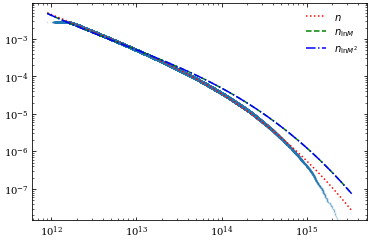

In [11]:
M_, n_, n_p_, n_pp_ = get_mass_func(M['ppm'], boxsize, n_splines=4)

plt_mass_func_scatter(M['ppm'], boxsize)
plt.plot(M_, n_, c='r', ls=':', label='$n$')
plt.plot(M_, n_p_, c='g', ls='--', label='$n_{\ln M}$')
plt.plot(M_, n_p_, c='b', ls='-.', label='$n_{{\ln M}^2}$')
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [43]:
ds_dlnM_mmp = CubicSpline(np.log(M_), shift_mmp).derivative(1)
ds_dlnM_ppm = CubicSpline(np.log(M_), shift_ppm).derivative(1)
shift_ = (shift_mmp + shift_ppm)/2

bLs2 = - (ds_dlnM_mmp(np.log(M_))+ds_dlnM_ppm(np.log(M_)))/2 - shift_* n_pp_

bLs2_mmp = -ds_dlnM_mmp(np.log(M_)) - shift_mmp* n_pp_
bLs2_ppm = -ds_dlnM_ppm(np.log(M_)) - shift_ppm* n_pp_

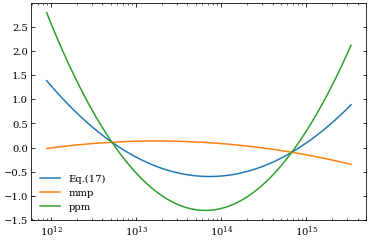

In [44]:
plt.plot(M_, 2*bLs2, ls='-', label='Eq.(17)')
plt.plot(M_, 2*bLs2_mmp, ls='-', label='mmp')
plt.plot(M_, 2*bLs2_ppm, ls='-', label='ppm')

#plt.plot(massbin, (bLs2_mmp+bLs2_ppm)/2., ls='--', label='Eq.(16)')

plt.xscale('log')
#plt.yscale('log')
#plt.xlim(1e12, 1e15)
#plt.ylim(-3, 6)
plt.legend()
#plt.savefig('/home/yinli/csit/analysis/bias/bLs2_abmat_0005.pdf')